In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import model.util as model_util
import model.profile_models as profile_models
import model.train_profile_model as train_profile_model
import model.binary_models as binary_models
import model.train_binary_model as train_binary_model
import feature.util as feature_util
import feature.make_profile_dataset as make_profile_dataset
import feature.make_binary_dataset as make_binary_dataset
import plot.viz_sequence as viz_sequence
import pandas as pd
import numpy as np
import torch
import tqdm
tqdm.tqdm_notebook()  # It is necessary to call this before the tqdm.notebook submodule is available
import matplotlib.pyplot as plt
import json
import scipy.stats

/users/amtseng/miniconda3/envs/att-priors/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


### Define paths for the model and data of interest

In [2]:
model_type = "binary"

In [3]:
# Shared paths/constants
reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
input_length = 1000 if model_type == "binary" else 1346
profile_length = 1000

In [4]:
# files_spec_path = "/users/amtseng/att_priors/data/processed/ENCODE_TFChIP/%s/config/SPI1/SPI1_training_paths.json" % model_type
# num_tasks = 4
# model_class = binary_models.BinaryPredictor if model_type == "binary" else profile_models.ProfilePredictorWithControls
# use_controls = True
# noprior_model_base_path = "/users/amtseng/att_priors/models/trained_models/%s_models/SPI1" % model_type
# prior_model_base_path = "/users/amtseng/att_priors/models/trained_models/%s_models/SPI1_prior" % model_type
# chrom_set = ["chr1"]

In [5]:
# files_spec_path = "/users/amtseng/att_priors/data/processed/ENCODE_TFChIP/%s/config/E2F6/E2F6_training_paths.json" % model_type
# num_tasks = 2
# model_class = binary_models.BinaryPredictor if model_type == "binary" else profile_models.ProfilePredictorWithControls
# use_controls = True
# noprior_model_base_path = "/users/amtseng/att_priors/models/trained_models/%s_models/E2F6_keep1" % model_type
# prior_model_base_path = "/users/amtseng/att_priors/models/trained_models/%s_models/E2F6_prior_keep1" % model_type
# chrom_set = ["chr1"]

In [6]:
files_spec_path = "/users/amtseng/att_priors/data/processed/ENCODE_DNase/%s/config/HepG2/HepG2_training_paths.json" % model_type
num_tasks = 2
model_class = binary_models.BinaryPredictor if model_type == "binary" else profile_models.ProfilePredictorWithoutControls
use_controls = False
noprior_model_base_path = "/users/amtseng/att_priors/models/trained_models/%s_models/HepG2_keep1" % model_type
prior_model_base_path = "/users/amtseng/att_priors/models/trained_models/%s_models/HepG2_prior_keep1" % model_type
chrom_set = ["chr1"]

In [7]:
# Extract the file specs
with open(files_spec_path, "r") as f:
    files_spec = json.load(f)
if model_type == "binary":
    labels_hdf5 = files_spec["labels_hdf5"]
    bin_labels_npy = files_spec["bin_labels_npy"]
else:
    peaks_bed = files_spec["peak_beds"][0]  # First peaks BED, arbitrarily
    profile_hdf5 = files_spec["profile_hdf5"]

In [8]:
torch.set_grad_enabled(True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [9]:
def import_metrics_json(model_base_path, run_num):
    """
    Looks in {model_base_path}/{run_num}/metrics.json and returns the contents as a
    Python dictionary. Returns None if the path does not exist.
    """
    path = os.path.join(model_base_path, str(run_num), "metrics.json")
    if not os.path.exists(path):
        return None
    with open(path, "r") as f:
        return json.load(f)

In [10]:
def get_model_paths(
    model_base_path, metric_name="val_prof_corr_losses",
    reduce_func=(lambda values: np.mean(values)), compare_func=(lambda x, y: x < y),
    print_found_values=True
):
    """
    Looks in `model_base_path` and for each run, returns the full path to
    the best epoch. By default, the best epoch in a run is determined by
    the lowest validation profile loss.
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(model_base_path, run_num) for run_num in os.listdir(model_base_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    model_paths = []
    for run_num in sorted(metrics.keys(), key=lambda x: int(x)):
        try:
            # Find the best epoch within that run
            best_epoch_in_run, best_val_in_run = None, None
            for i, subarr in enumerate(metrics[run_num][metric_name]["values"]):
                val = reduce_func(subarr)
                if best_val_in_run is None or compare_func(val, best_val_in_run):
                    best_epoch_in_run, best_val_in_run = i + 1, val
            model_path = os.path.join(model_base_path, run_num, "model_ckpt_epoch_%d.pt" % best_epoch_in_run)
            model_paths.append(model_path)
            if print_found_values:
                print("\tRun %s, epoch %d: %6.2f" % (run_num, best_epoch_in_run, best_val_in_run))
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return model_paths
        

In [11]:
metric_name = "val_prof_corr_losses" if model_type == "profile" else "val_corr_losses"

In [12]:
noprior_model_paths = get_model_paths(noprior_model_base_path, metric_name=metric_name)

	Run 1, epoch 5:   0.39
	Run 2, epoch 4:   0.37
	Run 3, epoch 2:   0.39
	Run 4, epoch 3:   0.37
	Run 5, epoch 3:   0.40
	Run 6, epoch 4:   0.36
	Run 7, epoch 4:   0.36
	Run 8, epoch 3:   0.36
	Run 9, epoch 4:   0.37
	Run 10, epoch 6:   0.40


In [13]:
prior_model_paths = get_model_paths(prior_model_base_path, metric_name=metric_name)

	Run 1, epoch 10:   0.37
	Run 2, epoch 10:   0.37
	Run 3, epoch 6:   0.38
	Run 4, epoch 8:   0.37
	Run 5, epoch 4:   0.37
	Run 6, epoch 10:   0.38
	Run 7, epoch 9:   0.37
	Run 8, epoch 7:   0.38
	Run 9, epoch 8:   0.35
	Run 10, epoch 5:   0.39


In [14]:
def restore_model(model_path):
    model = model_util.restore_model(model_class, model_path)
    model.eval()
    model = model.to(device)
    return model

### Data preparation
Use classes from `make_profile_dataset` to prepare positive and negative inputs.

In [15]:
# Maps coordinates to 1-hot encoded sequence
coords_to_seq = feature_util.CoordsToSeq(reference_fasta, center_size_to_use=input_length)

if model_type == "binary":
    # Maps bin index to profiles
    bins_to_vals = make_binary_dataset.BinsToVals(labels_hdf5)

    # Maps many bin indices to coordinates, inputs sequences, and output values for the network
    def bin_inds_to_network_inputs(bin_inds):
        coords, outout_vals = bins_to_vals(bin_inds) 
        input_seqs = coords_to_seq(coords)
        return coords, input_seqs, outout_vals
    
    # Import set of all labels
    labels_array = np.load(bin_labels_npy, allow_pickle=True)

    # Get set of positive and negative bin indices
    chrom_mask = np.isin(labels_array[:, 0], chrom_set)
    pos_examples = np.where(chrom_mask & (labels_array[:, 1] == 1))[0]
else:
    # Maps coordinates to profiles
    coords_to_vals = make_profile_dataset.CoordsToVals(profile_hdf5, profile_length)

    # Maps many coordinates to inputs sequences and profiles for the network
    def coords_to_network_inputs(coords):
        input_seq = coords_to_seq(coords)
        profs = coords_to_vals(coords)
        return input_seq, np.swapaxes(profs, 1, 2)
    # Import set of positive peaks
    pos_coords_table = pd.read_csv(peaks_bed, sep="\t", header=None, compression="gzip")
    # Filter for only the desired chromosomes
    pos_coords_table = pos_coords_table[pos_coords_table[0].isin(chrom_set)]
    pos_examples = pos_coords_table.values[:, :3]

### Predicting profiles

In [16]:
def get_input_grads(model, model_type, coords_or_bin_inds):
    """
    Fetches the necessary data from the given coordinates or bin indices
    and runs it through a profile or binary model. Returns the input
    gradients and the input sequences as NumPy arrays.
    """
    if model_type == "binary":
        coords, input_seqs_np, output_vals_np = bin_inds_to_network_inputs(coords_or_bin_inds)
        output_vals = model_util.place_tensor(torch.tensor(output_vals_np)).float()
    else:
        input_seqs_np, profiles = coords_to_network_inputs(coords_or_bin_inds)
        profiles = model_util.place_tensor(torch.tensor(profiles)).float()
        if use_controls:
            true_profs = profiles[:, :num_tasks, :, :]
            cont_profs = profiles[:, num_tasks:, :, :]
        else:
            true_profs, cont_profs = profiles, None
    input_seqs = model_util.place_tensor(torch.tensor(input_seqs_np)).float()

    model.zero_grad()
    
    # Run through the model
    input_seqs.requires_grad = True  # Set gradient required
    if model_type == "binary":
        output = model(input_seqs)
    else:
        output, _ = model(input_seqs, cont_profs)
    
    # Compute input gradients
    input_grads, = torch.autograd.grad(
        output, input_seqs,
        grad_outputs=model_util.place_tensor(torch.ones(output.size())),
        retain_graph=True, create_graph=True
    )
    input_grads_np = input_grads.detach().cpu().numpy()
    
    return input_grads_np, input_seqs_np

### Compute consistency

In [17]:
# Pick a sample of 100 random coordinates/bins
num_samples = 100
sample = pos_examples[np.random.choice(len(pos_examples), size=num_samples, replace=False)]

In [18]:
def compute_gradients(model_paths, sample, batch_size=128):
    """
    Given a list of paths to M models and a list of N coordinates, computes
    the input gradients over all models, returning an M x N x I x 4 array of
    gradient values and an N x I x 4 array of one-hot encoded sequence.
    """
    num_models, num_samples = len(model_paths), len(sample)
    
    num_batches = int(np.ceil(num_samples / batch_size))
    
    all_input_grads = np.empty((num_models, num_samples, input_length, 4))
    all_one_hot_seqs = np.empty((num_samples, input_length, 4))
    
    for i in tqdm.notebook.trange(num_models):
        model = restore_model(model_paths[i])
        for j in range(num_batches):
            batch_slice = slice(j * batch_size, (j + 1) * batch_size)
            batch = sample[batch_slice]
            input_grads, one_hot_seqs = get_input_grads(model, model_type, batch)
            all_input_grads[i, batch_slice] = input_grads
            if i == 0:
                all_one_hot_seqs[batch_slice] = one_hot_seqs
    return all_input_grads, all_one_hot_seqs

In [19]:
# Compute the gradients and 1-hot seqs
prior_grads, one_hot_seqs = compute_gradients(prior_model_paths, sample)
noprior_grads, _ = compute_gradients(noprior_model_paths, sample)

In [20]:
# # Plot out a few examples over some different models
# center_slice = slice(600, 700)
# for i in np.random.choice(num_samples, size=3):
#     print(sample[i])
#     print("=========================")
#     print("Without priors:")
#     print("---------------")
#     for j in np.random.choice(len(noprior_model_paths), size=3):
#         print("Model %d" % (j + 1))
#         viz_sequence.plot_weights(noprior_grads[j, i, center_slice] * one_hot_seqs[i, center_slice])
#     print("With priors:")
#     print("------------")
#     for j in np.random.choice(len(prior_model_paths), size=3):
#         print("Model %d" % (j + 1))
#         viz_sequence.plot_weights(prior_grads[j, i, center_slice] * one_hot_seqs[i, center_slice])

In [21]:
def cont_jaccard(seq_1, seq_2):
    """
    Takes two gradient sequences (I x 4 arrays) and computes a similarity between
    them, using a continuous Jaccard metric.
    """
    ab_1, ab_2 = np.abs(seq_1), np.abs(seq_2)
    inter = np.minimum(ab_1, ab_2) * np.sign(seq_1) * np.sign(seq_2)
    union = np.maximum(ab_1, ab_2)
    cont_jaccard = np.sum(inter, axis=1) / np.sum(union, axis=1)
    return np.sum(cont_jaccard)

In [22]:
def cosine_sim(seq_1, seq_2):
    """
    Takes two gradient sequences (I x 4 arrays) and computes a similarity between
    them, using a cosine similarity.
    """
    dot = np.sum(seq_1 * seq_2, axis=1)
    mag_1, mag_2 = np.sqrt(np.sum(seq_1 * seq_1, axis=1)), np.sqrt(np.sum(seq_2 * seq_2, axis=1))
    # Ensure that base with all 0 is given a similarity score of 0
    zero_mask = (mag_1 == 0) | (mag_2 == 0)
    mag_1[zero_mask] = 1
    mag_2[zero_mask] = 1
    return np.sum(dot / (mag_1 * mag_2))

In [23]:
def compute_similarity_matrix(input_grads, sim_func=cont_jaccard):
    """
    Given the M x N x I x 4 input gradients returned by `compute_gradients`,
    computes an N x M x M similarity matrix of similarity across models (i.e.
    each coordinate gets a similarity matrix across different models).
    By defaults uses the continuous Jaccard similarity score
    """
    num_models, num_coords = input_grads.shape[0], input_grads.shape[1]
    
    sim_mats = np.empty((num_coords, num_models, num_models))
    for i in tqdm.notebook.trange(num_coords):
        for j in range(num_models):
            sim_mats[i, j, j] = 0
            for k in range(j):
                sim_score = sim_func(input_grads[j][i], input_grads[k][i])
                sim_mats[i, j, k] = sim_score
                sim_mats[i, k, j] = sim_score
    return sim_mats

In [24]:
prior_sim_matrix = compute_similarity_matrix(prior_grads, sim_func=cosine_sim)
noprior_sim_matrix = compute_similarity_matrix(noprior_grads, sim_func=cosine_sim)

Average similarity without priors: 159.794358
Average similarity with priors: 131.081257
Test of difference of means: t = -17.875681, p = 0.000000


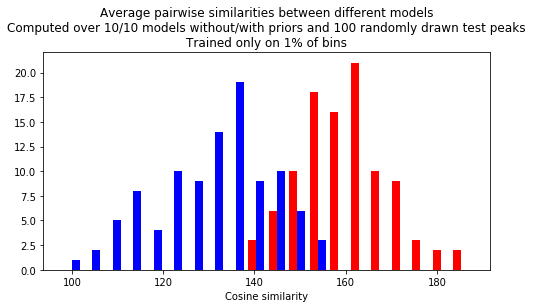

In [25]:
noprior_avg_sims, prior_avg_sims = [], []
bin_num = 20
for i in range(num_samples):
    noprior_avg_sims.append(np.nanmean(noprior_sim_matrix[i][np.tril_indices(len(noprior_model_paths), k=-1)]))
    prior_avg_sims.append(np.nanmean(prior_sim_matrix[i][np.tril_indices(len(prior_model_paths), k=-1)]))
plt.figure(figsize=(8, 4))
plt.hist(
    [noprior_avg_sims, prior_avg_sims],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"]
)
plt.title(
    "Average pairwise similarities between different models" +
    "\nComputed over %d/%d models without/with priors and 100 randomly drawn test peaks" % (len(noprior_model_paths), len(prior_model_paths)) +
    "\nTrained only on 1% of bins"
)
plt.xlabel("Cosine similarity")

print("Average similarity without priors: %f" % np.nanmean(noprior_avg_sims))
print("Average similarity with priors: %f" % np.nanmean(prior_avg_sims))
t, p = scipy.stats.ttest_ind(prior_avg_sims, noprior_avg_sims)
print("Test of difference of means: t = %f, p = %f" % (t, p / 2))